In [ ]:
#default_exp cactus
#export
import os
import tempfile

from dataclasses import dataclass
import kornia as K

import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as tfms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchnet
import pytorch_lightning as pl
from tqdm.auto import tqdm


from collections import OrderedDict, defaultdict
from functools import partial
from torch.utils.data import Dataset, DataLoader

from torchnet.dataset import ListDataset, TransformDataset
from torchmeta.utils.data import BatchMetaDataLoader
from sklearn.cluster import KMeans

from unsupervised_meta_learning.nn_utils import c_imshow

In [ ]:
%matplotlib inline

In [ ]:
#export
class Partition():
    def __init__(self, labels, n_way, n_shot, n_query):
        partition = defaultdict(list)
        cleaned_partition = {}
        for ind, label in enumerate(labels):
            partition[label].append(ind)
        for label in list(partition.keys()):
            if len(partition[label]) >= n_shot + n_query:
                cleaned_partition[label] = np.array(partition[label], dtype=np.int)
        self.partition = cleaned_partition
        self.subset_ids = np.array(list(cleaned_partition.keys()))

    def __getitem__(self, key):
        return self.partition[key]

In [ ]:
#export
class CactusTaskDataset(Dataset):
    def __init__(self, data, partitions, n_way, n_shot, n_query, length):
        self.data = data
        self.partitions = partitions
        self.n_way = n_way
        self.n_shot = n_shot
        self.n_query = n_query
        self.length = length
        self.iter = 0

    def reset(self):
        self.iter = 0

    def __iter__(self):
        return self

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return self.__next__()

    def __next__(self):
        if self.iter == self.length:
            raise StopIteration
        self.iter += 1

        i_partition = torch.randint(low=0, high=len(self.partitions), size=(1,), dtype=torch.int)
        partition = self.partitions[i_partition]
        sampled_subset_ids = np.random.choice(partition.subset_ids, size=self.n_way, replace=False)
        xs, xq = [], []
        for subset_id in sampled_subset_ids:
            indices = np.random.choice(partition[subset_id], self.n_shot + self.n_query, replace=False)
            x = self.data[indices]
            x = x.astype(np.float32) / 255.0
            if x.shape[1] != 1 and x.shape[1] != 3:
                x = np.transpose(x, [0, 3, 1, 2])
            x = torch.from_numpy(x)
            xs.append(x[:self.n_shot])
            xq.append(x[self.n_shot:])
        xs = torch.stack(xs, dim=0)
        xq = torch.stack(xq, dim=0)

        return {'train': xs, 'test': xq}

In [ ]:
#export
def get_partitions_kmeans(encodings, n_way, n_shot, n_query, random_scaling=True, n_partitions=100, n_clusters=500):
    tmp_dir = tempfile.TemporaryDirectory()
    os.environ['JOBLIB_TEMP_FOLDER'] = tmp_dir.name  # default runs out of space for parallel processing
    
    encodings_list = [encodings]
    
    if random_scaling:
        n_clusters_list = [n_clusters]
        for i in range(n_partitions - 1):
            weight_vector = np.random.uniform(low=0., high=1., size=encodings.shape[1])
            encodings_list.append(np.multiply(encodings, weight_vector))
            
    else:
        n_clusters_list = [n_clusters] * n_partitions
    
    assert len(encodings_list) * len(n_clusters_list) == n_partitions
    
    if n_partitions != 1:
        n_init = 3
        init = 'k-means++'
    else:
        n_init = 10
        init = 'k-means++'
    
    print('Number of encodings: {}, number of n_clusters: {}, number of inits: '.format(len(encodings_list),
                                                                                        len(n_clusters_list)), n_init)
    kmeans_list = []
    
    for n_clusters in tqdm(n_clusters_list, desc='get_partitions_kmeans_n_clusters'):
        for encodings in tqdm(encodings_list, desc='get_partitions_kmeans_encodings'):
            while True:
                kmeans = KMeans(n_clusters=n_clusters,
                                init=init,
                                n_init=n_init,
                                max_iter=3000).fit(encodings)
                uniques, counts = np.unique(kmeans.labels_, return_counts=True)
                num_big_enough_clusters = np.sum(counts >= n_shot + n_query)
                
                if num_big_enough_clusters > .8 * n_clusters:
                    break
                else:
                    tqdm.write("Too few classes ({}) with greater than {} examples.".format(num_big_enough_clusters,
                                                                                            n_shot + n_query))
                    tqdm.write('Frequency: {}'.format(counts))
            kmeans_list.append(kmeans)
    partitions = []
    for kmeans in kmeans_list:
        partitions.append(Partition(labels=kmeans.labels_, n_way=n_way, n_shot=n_shot, n_query=n_query))
    tmp_dir.cleanup()
    return partitions

In [ ]:
#export
@dataclass
class DataOpt:
    dataset: str = 'omniglot'
    encoder='acai'
    test_way: int = None
    way: int = 5
    test_shot: int = None
    shot: int = 1
    test_query: int = None
    query: int = 15
    test_episodes: int = None
    test_mode:int = None
    partitions:int = 100
    clusters:int = 500
    train_mode: str = 'kmeans'
    train_episodes: int = 100

@dataclass
class LoaderOpt:
    data: DataOpt

In [ ]:
dummy = DataOpt(
    dataset='omniglot',
    way=20,
    shot=1,
    query=15,
    train_mode='kmeans',
    train_episodes=100,
    partitions=1,
    clusters=500
)
l = LoaderOpt(data=dummy)

In [ ]:
#export
def load(opt:LoaderOpt, splits, data_dir):
    encodings_dir = os.path.join(data_dir, '{}_encodings'.format(opt.data.encoder))
    filenames = os.listdir(encodings_dir)
    
    ret = {}
    
    for split in splits:
        if split in ['val', 'test'] and opt.data.test_way != 0:
            n_way = opt.data.test_way
        else:
            n_way = opt.data.way

        if split in ['val', 'test'] and opt.data.test_shot != 0:
            n_support = opt.data.test_shot
        else:
            n_support = opt.data.shot

        if split in ['val', 'test'] and opt.data.test_query != 0:
            n_query = opt.data.test_query
        else:
            n_query = opt.data.query

        if split in ['val', 'test']:
            n_episodes = opt.data.test_episodes
            mode = opt.data.test_mode
        else:
            n_episodes = opt.data.train_episodes
            mode = opt.data.train_mode
        
        split_filename = [filename for filename in filenames if opt.data.dataset in filename and split in filename]
        split_filename = os.path.join(encodings_dir, split_filename[0])
        split_data = np.load(split_filename)
        images = split_data['X']    # (index, H, W, C)
        labels = split_data['Y']
        encodings = split_data['Z']
        
        if mode == 'ground_truth':
            if opt.data.dataset == 'celeba':
#                 TODO: need to change this part
                annotations_filename = os.path.join(DATA_DIR, 'celeba/cropped/Anno/list_attr_celeba.txt')
                partitions = celeba_partitions(labels=labels, split=split, annotations_filename=annotations_filename, n_way=n_way, n_shot=n_support, n_query=n_query)
            else:
                partitions = [Partition(labels=labels, n_way=n_way, n_shot=n_support, n_query=n_query)]

        elif mode == 'kmeans':
            partitions = get_partitions_kmeans(encodings=encodings, n_way=n_way, n_shot=n_support, n_query=n_query, n_partitions=opt.data.partitions, n_clusters=opt.data.clusters)

        elif mode == 'random':
            partitions = [Partition(labels=np.random.choice(opt.data.clusters, size=labels.shape, replace=True), n_way=n_way, n_shot=n_support, n_query=n_query) for i in range(opt.data.partitions)]
        else:
            raise ValueError
        ret[split] = CactusTaskDataset(data=images,
                                partitions=partitions,
                                n_way=n_way,
                                n_shot=n_support,
                                n_query=n_query,
                                length=n_episodes)

    return ret
    

In [ ]:
r = load(l, ['train'], data_dir='data/cactus_data/')

Number of encodings: 1, number of n_clusters: 1, number of inits:  10


get_partitions_kmeans_n_clusters:   0%|          | 0/1 [00:00<?, ?it/s]

get_partitions_kmeans_encodings:   0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-3-57a1d7989bcd>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cleaned_partition[label] = np.array(partition[label], dtype=np.int)


In [ ]:
torchnet.dataset.BatchDataset(r['train'], 8)[0]['train'].squeeze(2).shape

torch.Size([8, 5, 1, 28, 28])

In [ ]:
torchnet.dataset.TransformDataset(torchnet.dataset.BatchDataset(r['train'], 8),
                                 lambda x: {'train': x['train'].squeeze(2),
                                            'test': x['test'].view(8, -1, 1, 28, 28)
                                           })

In [ ]:
r['train'].reset()

In [ ]:
r['train']

In [ ]:
dl = DataLoader(r['train'], batch_size=8)

In [ ]:
next(iter(dl))['train'].shape

torch.Size([8, 5, 1, 1, 28, 28])

In [ ]:
c_imshow(torchvision.utils.make_grid(xs['train'][3]))

NameError: name 'xs' is not defined

In [ ]:
xs['test'].view(8, -1, 1, 28, 28)

torch.Size([8, 75, 1, 28, 28])

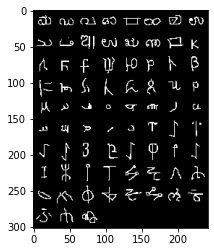

In [ ]:
c_imshow(torchvision.utils.make_grid(xs['test'].view(8, -1, 1, 28, 28)[3]))

In [ ]:
#export
class CactusDataModule(pl.LightningDataModule):
    def __init__(self,
                 ways,
                 shots,
                 query,
                 train_mode='kmeans',
                 train_episodes=100,
                 partitions=100,
                 clusters=500,
                 batch_size=1,
                 use_precomputed=False,
                 precomputed_partition_path=None,
                 dataset='omniglot'):
        self.use_precomputed = use_precomputed
        self.precomputed_partition_path = precomputed_partition_path
        self.dataset = dataset
        self.ways = ways
        self.shots = shots
        self.query_shots = query
        self.train_mode = train_mode
        self.train_episodes = train_episodes
        self.partitions = partitions
        self.clusters = clusters
    
    def setup(self):
        self.data_opt = DataOpt(
            dataset=self.dataset,
            way=self.ways,
            shot=self.shots,
            query=self.query_shots,
            train_mode=self.train_mode,
            train_episodes=self.train_episodes,
            partitions=self.partitions,
            clusters=self.clusters
        )
        self.loader_opt = LoaderOpt(data=dummy)
        self.train_ds = torchnet.dataset.TransformDataset(torchnet.dataset.BatchDataset(r['train'], self.batch_size),
                                 lambda x: {'train': x['train'].squeeze(2),
                                            'test': x['test'].view(self.batch_size, -1, 1, 28, 28)
                                           })
        
    def train_dataloader(self):
        return DataLoader(
            self.train_ds
        )
    
    def val_dataloader(self):
        pass
    
    def test_dataloader(self):
        pass

In [ ]:
dm = CactusDataModule(ways=5, shots=1, query=15)

In [ ]:
from nbdev.export import notebook2script; notebook2script()

Converted 01_nn_utils.ipynb.
Converted 01b_data_loaders_pl.ipynb.
Converted 01c_grad_utils.ipynb.
Converted 01d_hessian_free.ipynb.
Converted 02_maml_pl.ipynb.
Converted 02b_iMAML.ipynb.
Converted 03_protonet_pl.ipynb.
Converted 04_cactus.ipynb.
Converted index.ipynb.
